In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Import dataset

In [2]:
path = "C:/CodeTest1/Venv1/SalesFeb2023/"
file1 = "Query1.xlsx"
file2 = "Query2.xlsx"
df = pd.read_excel(path + file1)
df2 = pd.read_excel(path + file2)
# date_time = pd.to_datetime(df.pop('SalesDate'), format='%d.%m.%Y %H:%M:%S')


In [4]:
search_phrase = 'Aappakadai Indian Chettinad - Santa Clara, CA'
df = df.loc[df.CustomerName == search_phrase]
df = df.sort_values(by='SalesDate',ascending=True)
date_time = pd.to_datetime(df.pop('SalesDate'), format='%Y-%m-%d')
df.drop('CustomerName',axis=1,inplace=True)

df

,C_TotalSales
16080,3187.39
1955,2594.12
32056,8213.16
13071,6712.50
3068,6132.96
...,...
18611,5957.86
30155,5665.28
6669,2344.98
21861,3340.90


# Data Split

In [12]:
def data_split(df,tr_split =0.7,val_split = 0.2,test_split = 0.1):
    column_indices = {name: i for i, name in enumerate(df.columns)}
    df = df.copy()
    n = len(df)
    train_df = df[0:int(n*tr_split)]
    val_df = df[int(n*tr_split):int(n*(tr_split+val_split))]
    test_df = df[int(n*test_split):]
    return [train_df,val_df,test_df]

In [13]:
def z_transformation(df):
    mu = df.mean()
    sigma = df.std()
    z = (df - mu) / sigma
    return z

In [14]:
def z_trans_inv(z,df):
    mu = df.mean()
    sigma = df.std()
    x = (z*sigma) + mu
    return x

In [ ]:
transformed_df = z_transformation(df)


In [21]:
train_df = data_split(transformed_df,tr_split =0.7,val_split = 0.2,test_split = 0.1)[0]
val_df = data_split(transformed_df,tr_split =0.7,val_split = 0.2,test_split = 0.1)[1]
test_df = data_split(transformed_df,tr_split =0.7,val_split = 0.2,test_split = 0.1)[2]

In [23]:
tr = z_trans_inv(transformed_df,df)
tr

,C_TotalSales
16080,3187.39
1955,2594.12
32056,8213.16
13071,6712.50
3068,6132.96
...,...
18611,5957.86
30155,5665.28
6669,2344.98
21861,3340.90


# Construction of Input Windows

In [24]:
# Sliding Inout Window for  Models
#Width (Total number of timesteps for the input)
#Time  (offset to start the new input sequence)
# Which features for input and labels
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Model to predict one month into the future, using one month of data

In [25]:
w3 = WindowGenerator(input_width=30, label_width=30, shift=1,
                    label_columns=['C_TotalSales'])
w3

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['C_TotalSales']

## Splitting the Data

In [26]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [28]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w3.total_window_size]),
                           
                           np.array(train_df[50:50+w3.total_window_size]),
                          
                           np.array(train_df[100:100+w3.total_window_size])])

example_inputs, example_labels = w3.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 31, 1)
Inputs shape: (3, 30, 1)
Labels shape: (3, 30, 1)


In [30]:
w3.example = example_inputs, example_labels

In [31]:
def plot(self, model=None, plot_col='C_TotalSales', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

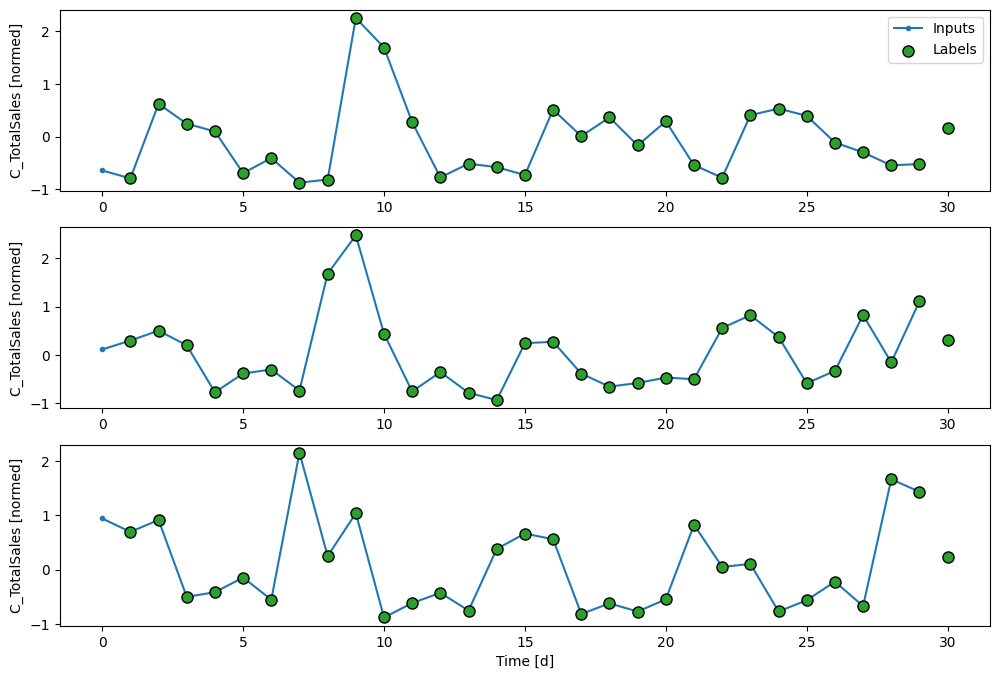

In [32]:
w3.plot()

## Create Tensorflow Dataset

In [33]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds
# Use Window Generator's train, val, test data
WindowGenerator.make_dataset = make_dataset

## Create DataFrames

In [34]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [35]:
# Each element is an (inputs, label) pair.
w3.train.element_spec

(TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))

In [36]:
# Use DataFrame Iterator to get labels
for example_inputs, example_labels in w3.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 1)
Labels shape (batch, time, features): (32, 30, 1)


# Linear Model

In [39]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['C_TotalSales'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['C_TotalSales']

In [40]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

# Package Training 

In [42]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [44]:
# Evaluate Linear Model
history = compile_and_fit(linear, wide_window)
val_performance ={}
performance = {}
val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

Epoch 1/20
6/6 [==============================] - 0s 25ms/step - loss: 1.0157 - mean_absolute_error: 0.6163 - val_loss: 1.5783 - val_mean_absolute_error: 0.7842
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 1.0119 - mean_absolute_error: 0.6159 - val_loss: 1.5710 - val_mean_absolute_error: 0.7824
Epoch 3/20
6/6 [==============================] - 0s 10ms/step - loss: 1.0087 - mean_absolute_error: 0.6157 - val_loss: 1.5637 - val_mean_absolute_error: 0.7814
Epoch 4/20
6/6 [==============================] - 0s 10ms/step - loss: 1.0049 - mean_absolute_error: 0.6156 - val_loss: 1.5565 - val_mean_absolute_error: 0.7801
Epoch 5/20
6/6 [==============================] - 0s 10ms/step - loss: 1.0016 - mean_absolute_error: 0.6153 - val_loss: 1.5496 - val_mean_absolute_error: 0.7789
Epoch 6/20
6/6 [==============================] - 0s 10ms/step - loss: 0.9982 - mean_absolute_error: 0.6150 - val_loss: 1.5430 - val_mean_absolute_error: 0.7776
Epoch 7/20
6/6 [===================

In [330]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


# Save Weights

In [48]:
path = 'C:/Users/TurnerJ/OneDrive/Desktop/Docker1/'

In [49]:
linear.save_weights(path + 'Weights')

In [51]:
tf.keras.models.save_model(linear, path, overwrite=True)

INFO:tensorflow:Assets written to: C:/Users/TurnerJ/OneDrive/Desktop/Docker1/assets


INFO:tensorflow:Assets written to: C:/Users/TurnerJ/OneDrive/Desktop/Docker1/assets


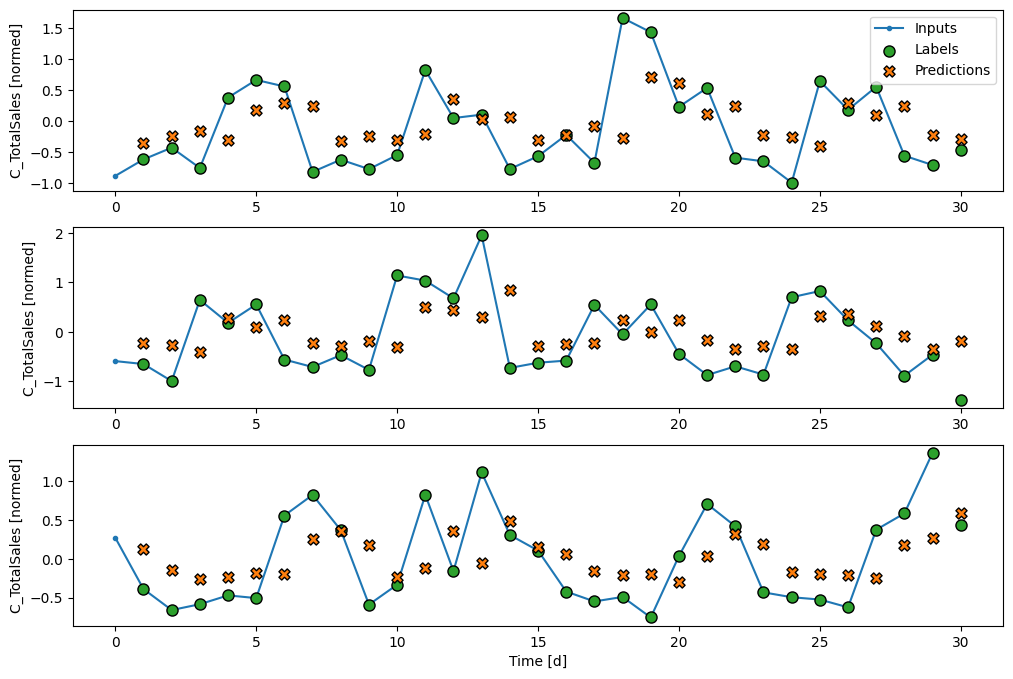

In [46]:
w3.plot(linear)

In [ ]:
#C:\Users\TurnerJ\OneDrive\Desktop\Docker1

# Save Model using Tensorflow

In [340]:
# save the model using TensorFlow
tf.keras.models.save_model(
    linear,
    'linear_model',
    overwrite=True,
    include_optimizer=True,
    save_format='tf'
)

INFO:tensorflow:Assets written to: linear_model\assets


INFO:tensorflow:Assets written to: linear_model\assets


# Tensorflow Serving

In [24]:
!which tensorflow_model_server

'which' is not recognized as an internal or external command,
operable program or batch file.


import requests

# Define the server endpoint
url = 'http://localhost:8501/v1/models/your_model_name/metadata'

# Send the metadata request to the server
response = requests.get(url)

# Get the model summary from the response
model_summary = response.json()

# Print the model summary
print(model_summary)


In [27]:
!tensorflow_model_server --port=9000 --model_name=linear_model --model_base_path=C:/CodeTest1/Venv1/SalesFeb2023/pringledatascience/pringledatascience/linear_model/

'tensorflow_model_server' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

save_model(
	model,
	export_path,
	overwrite=True,
	include_optimizer=True
)

print('\nSaved model:')
!ls -l {export_path}

# The command display input and output kayers with signature and data type
# These details are required when we make gRPC API call
!saved_model_cli show --dir {export_path} --all

# Create a compressed model from the savedmodel .
!tar -cz -f model.tar.gz --owner=0 --group=0 -C /tmp/1/ .


In [7]:
import requests
import json
import numpy as np

# Define the input data
input_data = np.array([[1.0]])

# Define the URL of the TensorFlow Serving server
url = 'http://localhost:9001/v1/models/linear_model:predict'

# Define the JSON request body
request_body = json.dumps({
    'instances': input_data.tolist()
})

# Send the HTTP POST request
response = requests.post(url, data=request_body)
response
# Parse the JSON response body
# response_body = json.loads(response.text)

# Extract the predictions from the response
# predictions = response_body['predictions']

# # Print the predictions
# print(predictions)


<Response [400]>

In [8]:
import requests
import json

# Define the input data
data = {
    "instances": [[7], [8], [9]]
}

# Send the request to the server
response = requests.post('http://localhost:9001/v1/models/linear_model:predict', json=data)

# Print the response
print(json.loads(response.text))

{'error': 'indices[0] = 2 is not in [0, 2)\n\t [[{{function_node __inference__wrapped_model_22249}}{{node sequential_3/dense_3/Tensordot/GatherV2_1}}]]'}


## Load tf model

In [7]:
import tensorflow as tf

# define the path to the directory where the SavedModel is stored
model_path = 'C:/CodeTest1/Venv1/SalesFeb2023/pringledatascience/pringledatascience/linear_model'

# load the model from the directory
model = tf.keras.models.load_model(model_path)

# make predictions using the loaded model
input_data = tf.constant([[[0.2]]])
predictions = model.predict(input_data)

print('Predictions:', predictions)


1/1 [==============================] - 0s 140ms/step
Predictions: [[[0.21317075]]]


In [11]:
model.input_shape

(None, None, 1)

In [9]:
import numpy as np

# assume input_data is the input data sent by the client
input_data = np.array([[[0.2]]])

# get the expected input shape of the model
expected_shape = model.input_shape

# compare the shape of the input data to the expected shape
if input_data.shape == expected_shape:
    print('Input data is in the correct shape.')
else:
    print('Input data is not in the correct shape.')


Input data is not in the correct shape.


In [14]:
# Saved model Directory 
model_dir = "./model"
model_version = 1
model_export_path = f"{model_dir}/{model_version}"

tf.saved_model.save(
    model,
    export_dir=model_export_path,
)

print(f"SavedModel files: {os.listdir(model_export_path)}")

INFO:tensorflow:Assets written to: ./model/1\assets


INFO:tensorflow:Assets written to: ./model/1\assets


SavedModel files: ['assets', 'fingerprint.pb', 'saved_model.pb', 'variables']


In [15]:
# Examine saved model
!saved_model_cli show --dir {model_export_path} --tag_set serve --signature_def serving_default


The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_3_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, 1)
      name: serving_default_dense_3_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


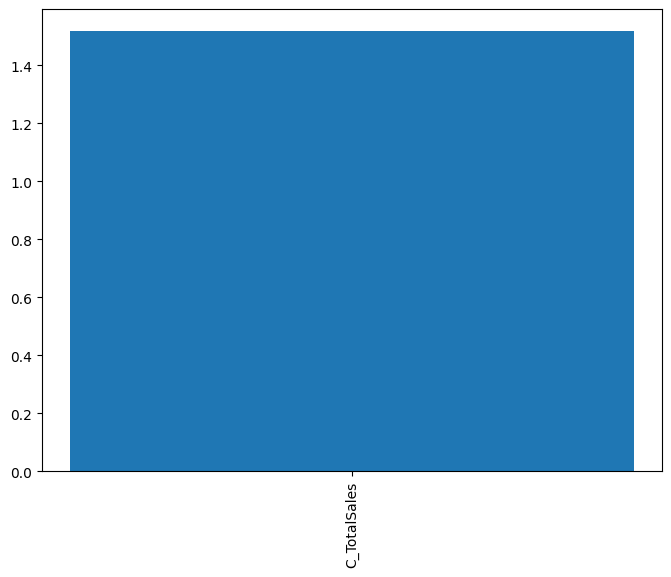

In [323]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [324]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
6/6 [==============================] - 1s 31ms/step - loss: 1.0037 - mean_absolute_error: 0.6382 - val_loss: 1.3078 - val_mean_absolute_error: 0.7196
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 0.9671 - mean_absolute_error: 0.6173 - val_loss: 1.3095 - val_mean_absolute_error: 0.7232
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 1.3358 - mean_absolute_error: 0.7192


In [327]:
import pickle

# train the model
linear.fit(wide_window.train)

# save the model as a pickle file
with open('baseline_model.pickle', 'wb') as f:
    pickle.dump(baseline, f)


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [2]:
import requests
import numpy as np

# define the input data
input_data = np.array([[[0.2]]])

# send the request to the server
response = requests.post('http://localhost:9000/v1/models/linear_model:predict', json={'inputs': input_data.tolist()})

# check if the response is valid
if response.ok:
    print('Model served successfully.')
    print('Predictions:', response.json()['outputs'])
else:
    print('Error:', response.status_code, response.text)


ConnectionError: ('Connection aborted.', BadStatusLine('ÿ\x00\x00\x00\x00\x00\x00\x00\x01\x7f'))

In [53]:
import requests

# Define the server endpoint
url = 'http://localhost:8501/v1/models/serving_base/metadata'

# Send the metadata request to the server
response = requests.get(url)

# Get the model summary from the response
model_summary = response.json()

# Print the model summary
print(model_summary)


ConnectionError: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/serving_base/metadata (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000151FE6A37F0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))